In [4]:
!pip install tqdm

In [5]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from time import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import random
import torch 
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO

In [6]:
random_seed = 2109
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

data_dir = "/opt/ml/segmentation/input/data/"
json_all_path = "/opt/ml/segmentation/input/data/train_all.json"
json_eval_path = "/opt/ml/segmentation/input/data/val.json"
# json_all_data json_eval_data 

In [7]:
category_names = ['Backgroud',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir,img_path, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.img_path =img_path
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(self.img_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self):
        # 전체 dataset의 size를 return
        # return 50
        return len(self.coco.getImgIds())

# image size, rgb mean, std

In [8]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        img = np.array(Image.open(os.path.join(img_dir, img_id)))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [9]:
# trian
with open(json_all_path, 'r') as j :
    json_all_data = json.load(j)
    img_all_file = []
    
for x in json_all_data["images"]:
    img_all_file.append(x["file_name"])
    
# eval
with open(json_eval_path, 'r') as j :
    json_eval_data = json.load(j)
    img_eval_file = []
    
for x in json_eval_data["images"]:
    img_eval_file.append(x["file_name"])

In [10]:
# img_all_info = get_img_stats(data_dir, img_all_file)
# img_eval_info = get_img_stats(data_dir, img_eval_file)

### Train

In [11]:
# print(f'Total number of images is {len(img_all_file)}')
# print()
# print(f'Minimum height for dataset is {np.min(img_all_info["heights"])}')
# print(f'Maximum height for dataset is {np.max(img_all_info["heights"])}')
# print(f'Average height for dataset is {int(np.mean(img_all_info["heights"]))}')
# print(f'Minimum width for dataset is {np.min(img_all_info["widths"])}')
# print(f'Maximum width for dataset is {np.max(img_all_info["widths"])}')
# print(f'Average width for dataset is {int(np.mean(img_all_info["widths"]))}')
# print()
# print(f'RGB Mean: {np.mean(img_all_info["means"], axis=0) / 255.}')
# print(f'RGB Standard Deviation: {np.mean(img_all_info["stds"], axis=0) / 255.}')

### Eval

In [12]:
# print(f'Total number of images is {len(img_eval_file)}')
# print()
# print(f'Minimum height for dataset is {np.min(img_eval_info["heights"])}')
# print(f'Maximum height for dataset is {np.max(img_eval_info["heights"])}')
# print(f'Average height for dataset is {int(np.mean(img_eval_info["heights"]))}')
# print(f'Minimum width for dataset is {np.min(img_eval_info["widths"])}')
# print(f'Maximum width for dataset is {np.max(img_eval_info["widths"])}')
# print(f'Average width for dataset is {int(np.mean(img_eval_info["widths"]))}')
# print()
# print(f'RGB Mean: {np.mean(img_eval_info["means"], axis=0) / 255.}')
# print(f'RGB Standard Deviation: {np.mean(img_eval_info["stds"], axis=0) / 255.}')

# EDA

# validation cv 전략?? 

In [13]:
# ann_path = json_all_path
ann_path = "/opt/ml/segmentation/input/data/train_all.json"
img_path ="/opt/ml/segmentation/input/data/"
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            # A.GridDropout(holes_number_x =30, holes_number_y=30, p=1.0),
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=ann_path, img_path = img_path, mode='train', transform=train_transform)
print(len(train_dataset))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.00s)
creating index...
index created!
3272


In [14]:
images, masks, image_infos =train_dataset[0]

In [15]:
np.unique(masks)

array([0, 5, 6, 8], dtype=int8)

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'General trash'}]


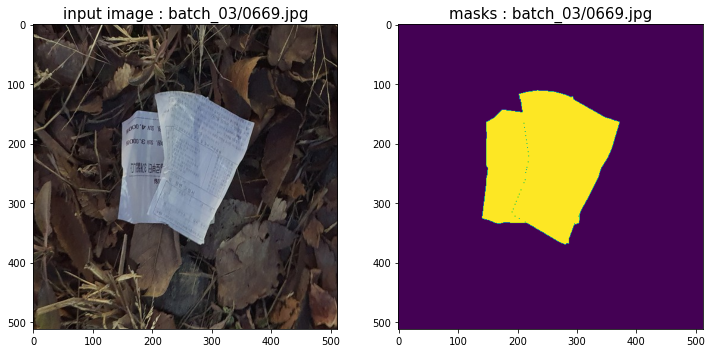

In [16]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

# temp_images, temp_masks, image_infos =  train_dataset[1583] train 확인 하기 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [17]:
# https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
# https://github.com/trent-b/iterative-stratification
# https://cvml.tistory.com/25
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit,
                                     StratifiedGroupKFold)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

In [18]:
anns = json_all_data["annotations"]
# print(anns[0])
cat_histogram = np.zeros(10,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

cat_name =  ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

print(cat_histogram)
print(cat_histogram)
test = []
for i, x in enumerate(cat_histogram):
    test.extend([i] * x)
# print([ [i] * x for i, x in enumerate(cat_histogram)])
len(test)

[2782 9311  659  562  610 3090 1343 7643   63  177]
[2782 9311  659  562  610 3090 1343 7643   63  177]


26240

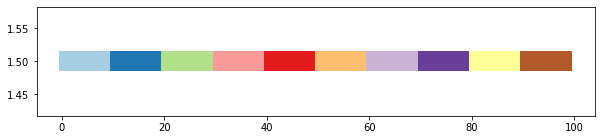

In [19]:
groups = np.hstack([[ii] * 10 for ii in range(10)])
fig, ax = plt.subplots(figsize = (10, 2))
ax.scatter(range(len(groups)),  [1.5] * len(groups),marker='_', c=groups, lw = 20, cmap= plt.cm.Paired)

In [20]:
# # Generate the class/group data
# n_points = 100
# X = np.random.randn(100, 10)

# percentiles_classes = [.1, .3, .6]
# y = np.hstack([[ii] * int(100 * perc)
#                for ii, perc in enumerate(percentiles_classes)])


# # Evenly spaced groups repeated once
# groups = np.hstack([[ii] * 2624 for ii in range(10)])

# def visualize_groups(classes, groups, name):
#     # Visualize dataset groups
#     fig, ax = plt.subplots(figsize = (30, 5))
#     # ax.scatter(range(len(classes)),  [.7] * len(groups), c=groups, marker='_',
#     #            lw=50, cmap=cmap_data)
#     ax.scatter(range(len(classes)),  [3.5] * len(classes), c=classes, marker='_',
#                lw=50, cmap=cmap_data)
#     ax.set(yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")
#             #ylim=[-1, 5], yticks=[0.7, 3.5],


# visualize_groups(test, groups, 'no groups')

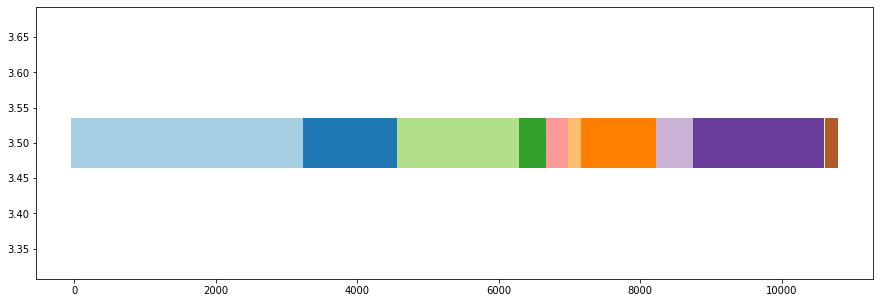

In [21]:
category = []
for index in range(len(train_dataset)):
    images, masks, image_infos =train_dataset[index]
    categorys = np.unique(masks)
    for cat in categorys:
        # category, id
        category.append([cat, index])

# cat 고리별 id 별 sort
category.sort(key= lambda x: (x[0], x[1]))
scater_all = []
for cat, _id in category:
    scater_all.append(cat)


fig, ax = plt.subplots(figsize = (15, 5))

ax.scatter(range(len(scater_all)),  [3.5] * len(scater_all), c=scater_all, marker='_',
            lw=50, cmap=cmap_data)
# ax.set(yticklabels=['Data\nclass'], xlabel="Sample index")


In [22]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [23]:
x, y, z = train_dataset[10]
print(y.shape)
print(z)

torch.Size([512, 512])
{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0014.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 10}


In [24]:
# # Kfold
# category = []
# # 전체를 구한다. 
# for index in range(len(train_dataset)):
#     images, masks, image_infos =train_dataset[index]
#     categorys = np.unique(masks)
#     for cat in categorys:
#         if cat == 0: 
#             continue
#         # category, id
#         category.append([cat, index])

# # cat 고리별 id 별 sort
# category.sort(key= lambda x: (x[0], x[1]))
# scater_all = []
# for cat, _id in category:
#     scater_all.append(cat)


# # 전체 scater_all
# fig, ax = plt.subplots(figsize = (20, 10))


# # ax.set(yticklabels=['Data\nclass'], xlabel="Sample index")


# kfold = KFold(n_splits=5, shuffle=False, random_state=None)

# for i, (train_index, val_index) in enumerate(kfold.split(train_dataset)):
#     # print(f"train {train_index}, val {val_index}")
#     kfod = []
#     for x in range(len(train_dataset)):
#         images, masks, image_infos =train_dataset[x]
#         categorys = np.unique(masks)
#         for cat in categorys:
#             if cat == 0: 
#                 continue
#             kfod.append([cat, x])
#     kfod.sort(key= lambda x: (x[0], x[1]))
#     scater_kfod = []
#     for cat, _id in kfod:
#         if _id in val_index:
#             scater_kfod.append(1)
#         else:
#             scater_kfod.append(0)
#     ax.scatter(range(len(scater_kfod)),  [(i+2) * 1.5 ]* len(scater_kfod), c=scater_kfod, marker='_',
#                 lw=50, cmap=cmap_data)
 

# ax.scatter(range(len(scater_all)),  [1.5] * len(scater_all), c=scater_all, marker='_',
#             lw=50, cmap=cmap_data)

In [25]:
np.unique(scater_all)
print(f"{2} : {scater_all.count(1)}")
print(f"{3} : {scater_all.count(2)}")
print(f"{4} : {scater_all.count(3)}")
print(f"{5} : {scater_all.count(4)}")
print(f"{6} : {scater_all.count(5)}")
print(f"{7} : {scater_all.count(6)}")
print(f"{8} : {scater_all.count(7)}")
print(f"{9} : {scater_all.count(8)}")
print(f"{10} : {scater_all.count(9)}")
print(f"{11} : {scater_all.count(10)}")

print(len(scater_all))

2 : 1338
3 : 1726
4 : 380
5 : 301
6 : 183
7 : 1061
8 : 523
9 : 1853
10 : 16
11 : 110
10763


In [26]:
img_path ="/opt/ml/segmentation/input/data/"
ann_train_path = "/opt/ml/segmentation/input/data/train.json"
ann_val_path = "/opt/ml/segmentation/input/data/val.json"

# with open(ann_train_path, "r") as j:
#     train_json_data= json.load(j)

# with open(ann_val_path, "r") as j:
#     val_json_data = json.load(j)

train_json_set= CustomDataLoader(ann_train_path, img_path, mode='train', transform=train_transform)

loading annotations into memory...
Done (t=4.27s)
creating index...
index created!


In [27]:
train_files = []
for x in range(len(train_json_set)):
    _, _, infos = train_json_set[x]
    if infos["file_name"] not in train_files:
        train_files.append(infos["file_name"])

In [28]:
print(len(train_files))
print(train_files[:10])

2617
['batch_01_vt/0003.jpg', 'batch_01_vt/0005.jpg', 'batch_01_vt/0006.jpg', 'batch_01_vt/0007.jpg', 'batch_01_vt/0010.jpg', 'batch_01_vt/0011.jpg', 'batch_01_vt/0012.jpg', 'batch_01_vt/0013.jpg', 'batch_01_vt/0014.jpg', 'batch_01_vt/0015.jpg']


In [29]:
val_json_set= CustomDataLoader(ann_val_path, img_path, mode='train', transform=train_transform)

loading annotations into memory...
Done (t=2.00s)
creating index...
index created!


In [30]:
val_files = []
for x in range(len(val_json_set)):
    _, _, infos = val_json_set[x]
    if infos["file_name"] not in val_files:
        val_files.append(infos["file_name"])

In [31]:
print(len(val_files))
print(val_files[:10])

655
['batch_01_vt/0002.jpg', 'batch_01_vt/0009.jpg', 'batch_01_vt/0018.jpg', 'batch_01_vt/0019.jpg', 'batch_01_vt/0030.jpg', 'batch_01_vt/0035.jpg', 'batch_01_vt/0036.jpg', 'batch_01_vt/0042.jpg', 'batch_01_vt/0043.jpg', 'batch_01_vt/0051.jpg']


In [32]:
# Kfold
category = []
# 전체를 구한다. 
for index in range(len(train_dataset)):
    images, masks, image_infos =train_dataset[index]
    categorys = np.unique(masks)
    for cat in categorys:
        if cat == 0: 
            continue
        # category, id
        if image_infos["file_name"] in val_files:
            category.append([cat, 1])
        else:
            category.append([cat, 0])

# cat 고리별 id 별 sort
category.sort(key= lambda x: (x[0], x[1]))
scater_all = []
for cat, _id in category:
    scater_all.append(cat)

In [33]:
split_data_set =[]
for cat, is_val in category:
    split_data_set.append(is_val)

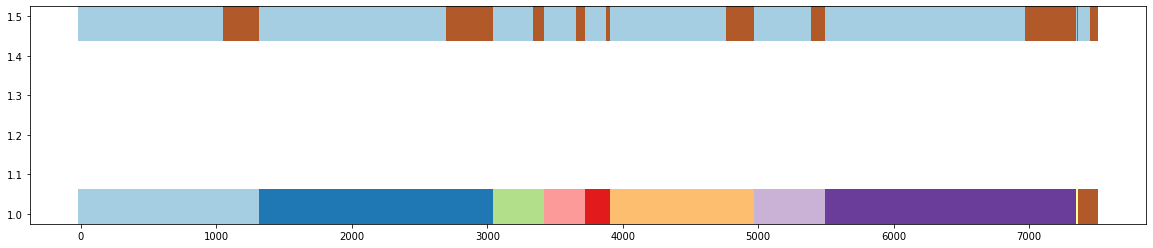

In [34]:
fig, ax = plt.subplots(figsize = (20, 4))

ax.scatter(range(len(split_data_set)),  [1.5]* len(split_data_set), c= split_data_set, marker='_', lw=50, cmap=cmap_data)
ax.scatter(range(len(scater_all)),  [1] * len(scater_all), c=scater_all, marker='_', lw=50, cmap=cmap_data)

In [35]:
# classes_list = []
# classes_list2 = []
# for x in range(len(train_dataset)):
#     images, masks, image_infos =train_dataset[x]
#     categorys = list(np.unique(masks))
#     # categorys.remove(0)
#     classes_list.extend(categorys)
#     classes_list2.append(categorys)
images, masks, image_infos =train_dataset[5]
list(np.unique(masks))
print(classes_list2[:10])

NameError: name 'classes_list2' is not defined

In [37]:
from collections import Counter
# Counter(classes_list)
# print(Counter(classes_list2))
# print(len(classes_list2))
js_classes = [4, 0, 5, 3, 5, 5, 0, 0, 0, 2, 2, 3, 7, 6, 0, 7, 0, 6, 0, 0, 0, 0, 7, 2, 5, 0, 2, 0, 9, 3, 1, 0, 0, 0, 5, 4, 0, 0, 0, 1, 3, 3, 0, 5, 0, 7, 1, 9, 2, 0, 5, 2, 9, 6, 4, 0, 2, 6, 6, 7, 0, 2, 6, 6, 3, 0, 3, 0, 0, 3, 4, 3, 7, 0, 2, 5, 7, 4, 0, 5, 6, 0, 2, 0, 1, 7, 5, 2, 0, 6, 2, 2, 3, 5, 2, 3, 4, 2, 3, 7, 6, 9, 9, 7, 3, 8, 7, 3, 7, 5, 7, 0, 0, 7, 1, 8, 4, 4, 5, 5, 5, 0, 9, 9, 4, 6, 1, 3, 5, 0, 5, 5, 3, 9, 9, 4, 4, 8, 9, 9, 9, 4, 4, 4, 9, 4, 9, 4, 3, 4, 4, 4, 4, 8, 9, 4, 9, 0, 4, 4, 4, 1, 4, 0, 4, 8, 8, 4, 8, 3, 1, 0, 5, 0, 5, 1, 7, 0, 0, 7, 1, 5, 0, 5, 0, 7, 0, 2, 0, 5, 1, 5, 1, 7, 0, 2, 0, 2, 1, 9, 7, 2, 7, 1, 6, 5, 1, 4, 5, 5, 5, 5, 2, 3, 4, 7, 5, 0, 3, 5, 5, 7, 0, 7, 3, 5, 7, 2, 4, 0, 0, 2, 6, 9, 6, 7, 2, 5, 3, 3, 9, 0, 1, 5, 3, 2, 2, 6, 5, 0, 7, 0, 7, 7, 5, 5, 2, 5, 7, 7, 9, 7, 1, 2, 2, 2, 8, 5, 3, 3, 5, 0, 7, 2, 0, 3, 1, 0, 0, 7, 6, 5, 6, 6, 3, 0, 0, 0, 2, 2, 0, 0, 7, 0, 1, 3, 0, 3, 2, 4, 5, 2, 7, 5, 0, 0, 0, 3, 1, 0, 7, 0, 5, 7, 0, 1, 0, 5, 5, 1, 5, 0, 2, 2, 0, 0, 2, 1, 1, 7, 5, 5, 0, 3, 0, 7, 6, 0, 2, 0, 5, 0, 0, 3, 6, 6, 5, 3, 3, 1, 1, 1, 3, 7, 5, 9, 7, 4, 5, 6, 5, 0, 2, 7, 3, 9, 0, 3, 0, 7, 5, 3, 0, 7, 5, 1, 1, 5, 1, 0, 1, 2, 2, 7, 7, 2, 7, 0, 7, 0, 6, 7, 6, 0, 6, 0, 3, 5, 3, 5, 2, 0, 7, 0, 2, 4, 2, 0, 7, 2, 0, 0, 0, 3, 7, 0, 1, 4, 4, 5, 3, 1, 0, 2, 0, 6, 1, 7, 0, 0, 5, 5, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 2, 6, 7, 0, 0, 0, 6, 6, 0, 6, 3, 0, 2, 0, 6, 5, 7, 3, 2, 7, 5, 7, 0, 1, 5, 0, 2, 4, 7, 0, 2, 1, 5, 1, 0, 3, 9, 0, 6, 1, 0, 4, 1, 1, 0, 5, 6, 7, 0, 1, 5, 3, 2, 7, 0, 2, 2, 7, 3, 1, 9, 3, 0, 3, 6, 9, 1, 2, 7, 7, 0, 3, 0, 3, 4, 5, 0, 5, 5, 3, 3, 0, 4, 5, 5, 0, 5, 3, 1, 5, 2, 3, 6, 1, 5, 7, 1, 0, 0, 4, 0, 3, 0, 0, 2, 1, 1, 4, 7, 0, 4, 0, 3, 5, 6, 2, 1, 0, 7, 6, 2, 3, 2, 0, 7, 2, 3, 5, 0, 3, 9, 7, 2, 3, 2, 5, 0, 3, 0, 5, 0, 7, 5, 1, 7, 5, 7, 7, 9, 3, 0, 0, 2, 5, 3, 0, 7, 7, 0, 5, 6, 6, 1, 9, 5, 5, 0, 6, 7, 5, 0, 3, 7, 3, 6, 5, 1, 0, 3, 3, 5, 1, 7, 1, 7, 0, 3, 2, 7, 1, 2, 1, 1, 1, 1, 7, 5, 5, 7, 3, 0, 1, 0, 0, 3, 0, 0, 7, 6, 0, 0, 7, 0, 7, 3, 0, 5, 5, 5, 2, 1, 2, 0, 7, 1, 2, 4, 2, 3, 0, 3, 1, 0, 7, 0, 0, 2, 0, 5, 2, 0, 2, 5, 1, 4, 2, 4, 3, 7, 3, 2, 7, 1, 3, 5, 1, 1, 7, 7, 2, 2, 2, 1, 0, 5, 6, 1, 1, 0, 1, 1, 3, 0, 2, 7, 0, 3, 2, 5, 2, 2, 4, 2, 5, 0, 5, 5, 5, 6, 6, 0, 3, 2, 0, 0, 3, 2, 3, 2, 4, 0, 2, 3, 5, 5, 4, 5, 2, 3, 6, 2, 4, 6, 5, 8, 2, 3, 6, 7, 7, 3, 5, 3, 3, 9, 5, 0, 3, 4, 5, 5, 7, 7, 0, 0, 0, 6, 6, 0, 5, 6, 4, 4, 0, 5, 0, 5, 5, 6, 6, 1, 1, 0, 1, 1, 7, 2, 2, 2, 5, 1, 0, 3, 3, 2, 2, 1, 0, 5, 7, 6, 6, 8, 3, 6, 6, 9, 5, 2, 6, 9, 1, 4, 9, 7, 7, 6, 7, 4, 7, 3, 0, 1, 7, 8, 7, 3, 5, 6, 0, 1, 7, 0, 6, 6, 6, 7, 0, 1, 7, 7, 0, 0, 1, 6, 6, 6, 1, 7, 1, 7, 6, 0, 3, 7, 3, 2, 5, 0, 1, 3, 1, 3, 6, 0, 1, 5, 4, 5, 9, 2, 2, 2, 4, 2, 5, 3, 0, 6, 1, 7, 7, 0, 7, 2, 0, 5, 7, 7, 5, 0, 6, 5, 5, 7, 5, 3, 6, 2, 6, 7, 7, 6, 6, 3, 7, 2, 0, 6, 6, 6, 2, 7, 7, 2, 7, 5, 6, 0, 8, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 7, 3, 5, 1, 1, 5, 6, 6, 0, 0, 6, 5, 6, 7, 6, 0, 0, 6, 7, 4, 6, 6, 1, 2, 7, 7, 0, 0, 7, 6, 3, 6, 6, 0, 6, 6, 6, 5, 3, 6, 6, 6, 0, 7, 0, 2, 5, 3, 7, 1, 0, 7, 0, 6, 1, 2, 5, 1, 7, 1, 6, 6, 5, 5, 6, 1, 5, 0, 2, 6, 6, 7, 2, 2, 7, 1, 7, 0, 1, 1, 4, 9, 1, 7, 0, 0, 5, 3, 0, 4, 7, 0, 5, 7, 1, 6, 6, 6, 0, 0, 7, 5, 6, 9, 6, 0, 0, 6, 7, 4, 5, 6, 7, 6, 6, 6, 7, 6, 3, 6, 0, 6, 6, 5, 5, 1, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 5, 7, 6, 6, 6, 6, 0, 6, 7, 0, 3, 9, 2, 6, 5, 2, 7, 0, 0, 3, 5, 7, 6, 0, 0, 0, 0, 1, 5, 1, 1, 0, 6, 1, 7, 7, 6, 1, 0, 1, 2, 6, 3, 6, 1, 0, 6, 3, 9, 4, 1, 1, 7, 1, 4, 1, 0, 5, 0, 1, 5, 6, 7, 7, 1, 5, 1, 7, 7, 7, 0, 0, 7, 7, 1, 1, 0, 1, 4, 3, 6, 7, 7, 5, 6, 1, 5, 0, 7, 1, 0, 4, 9, 0, 2, 0, 6, 0, 6, 0, 6, 6, 5, 0, 3, 1, 6, 7, 6, 6, 6, 1, 6, 6, 0, 3, 1, 4, 2, 6, 1, 7, 1, 0, 1, 3, 3, 3, 3, 3, 0, 5, 3, 7, 1, 1, 3, 2, 4, 4, 3, 6, 1, 3, 2, 1, 0, 0, 4, 0, 2, 2, 3, 5, 6, 1, 0, 5, 0, 0, 4, 6, 3, 3, 2, 4, 7, 1, 5, 7, 0, 7, 2, 6, 0, 0, 0, 6, 5, 0, 0, 6, 1, 5, 2, 0, 9, 3, 5, 7, 3, 2, 3, 2, 6, 7, 6, 1, 4, 1, 6, 6, 7, 0, 7, 1, 4, 5, 6, 3, 7, 0, 6, 1, 0, 7, 6, 5, 4, 7, 5, 2, 7, 0, 5, 0, 9, 2, 7, 0, 0, 7, 0, 4, 3, 4, 5, 7, 7, 0, 7, 2, 0, 5, 6, 0, 6, 2, 3, 6, 7, 0, 5, 6, 6, 2, 6, 5, 7, 7, 5, 9, 2, 9, 0, 6, 0, 7, 4, 7, 1, 6, 0, 6, 3, 0, 0, 2, 1, 7, 6, 1, 6, 0, 6, 6, 5, 2, 7, 4, 4, 1, 0, 5, 1, 1, 6, 4, 5, 6, 6, 6, 2, 7, 7, 0, 7, 0, 7, 2, 2, 4, 7, 7, 0, 1, 6, 6, 7, 6, 0, 7, 7, 6, 0, 6, 6, 5, 2, 0, 0, 7, 6, 7, 7, 6, 7, 3, 3, 6, 6, 3, 0, 6, 6, 6, 6, 3, 6, 0, 7, 3, 7, 3, 2, 0, 6, 0, 2, 5, 6, 0, 6, 2, 6, 6, 0, 4, 0, 7, 0, 6, 0, 6, 6, 4, 0, 6, 6, 0, 6, 6, 0, 7, 6, 6, 6, 4, 0, 1, 7, 7, 6, 7, 5, 6, 1, 0, 7, 1, 6, 0, 7, 7, 2, 4, 6, 0, 4, 3, 0, 7, 1, 7, 0, 4, 0, 4, 6, 0, 1, 0, 6, 9, 2, 0, 7, 2, 6, 2, 6, 0, 5, 0, 6, 5, 0, 0, 0, 2, 9, 3, 7, 4, 2, 1, 0, 5, 7, 0, 0, 7, 2, 7, 5, 6, 0, 2, 1, 4, 0, 9, 2, 2, 1, 2, 1, 0, 6, 5, 1, 0, 9, 0, 0, 6, 2, 0, 6, 3, 0, 6, 6, 6, 9, 0, 0, 2, 7, 2, 0, 7, 0, 2, 0, 0, 2, 0, 7, 0, 0, 3, 1, 1, 3, 5, 0, 1, 2, 6, 1, 6, 5, 7, 4, 7, 0, 6, 6, 7, 2, 7, 6, 7, 6, 3, 0, 6, 2, 7, 7, 3, 6, 0, 7, 1, 6, 7, 7, 3, 7, 5, 1, 0, 6, 6, 7, 6, 0, 0, 0, 0, 1, 0, 6, 4, 7, 5, 1, 4, 0, 6, 7, 1, 6, 6, 7, 1, 3, 3, 5, 0, 5, 3, 1, 7, 2, 6, 0, 7, 6, 7, 4, 0, 7, 6, 7, 6, 1, 7, 9, 7, 5, 5, 0, 6, 6, 2, 6, 0, 2, 6, 4, 7, 7, 6, 0, 0, 2, 5, 9, 3, 6, 7, 1, 2, 0, 6, 9, 3, 7, 9, 2, 3, 2, 2, 2, 6, 6, 6, 2, 6, 0, 2, 7, 2, 6, 6, 1, 5, 7, 4, 0, 5, 5, 0, 0, 7, 1, 0, 7, 0, 2, 2, 0, 3, 7, 1, 4, 3, 7, 0, 5, 7, 6, 2, 4, 6, 7, 7, 3, 5, 0, 6, 4, 0, 1, 6, 6, 5, 2, 6, 7, 6, 7, 1, 7, 0, 1, 7, 9, 2, 6, 6, 5, 5, 2, 0, 5, 0, 0, 7, 7, 2, 6, 6, 5, 7, 5, 7, 5, 6, 4, 1, 5, 5, 0, 7, 7, 6, 4, 6, 0, 7, 6, 6, 7, 1, 6, 2, 0, 0, 7, 7, 6, 3, 0, 7, 5, 7, 2, 7, 2, 2, 4, 6, 3, 6, 6, 6, 9, 7, 6, 0, 2, 7, 7, 5, 7, 0, 0, 3, 5, 0, 5, 6, 1, 6, 6, 6, 7, 9, 3, 3, 0, 3, 3, 3, 2, 4, 9, 0, 7, 6, 2, 2, 2, 3, 3, 4, 7, 7, 1, 0, 7, 6, 1, 0, 0, 6, 5, 0, 6, 0, 1, 6, 6, 7, 1, 0, 2, 7, 6, 7, 0, 0, 0, 1, 0, 3, 3, 5, 6, 1, 4, 0, 4, 6, 2, 2, 0, 2, 2, 6, 3, 7, 0, 3, 0, 2, 2, 6, 3, 6, 7, 0, 3, 2, 2, 6, 4, 2, 1, 6, 0, 0, 6, 6, 3, 6, 6, 6, 7, 7, 4, 6, 1, 0, 2, 4, 0, 6, 3, 3, 0, 3, 7, 6, 0, 7, 9, 6, 7, 0, 7, 7, 0, 7, 0, 1, 2, 0, 3, 0, 0, 0, 7, 3, 0, 9, 7, 0, 2, 7, 2, 7, 2, 7, 0, 2, 0, 0, 7, 0, 6, 5, 0, 5, 2, 0, 0, 3, 3, 3, 0, 9, 2, 6, 6, 2, 6, 2, 3, 0, 5, 1, 7, 2, 3, 3, 1, 5, 5, 4, 5, 0, 0, 5, 6, 5, 0, 9, 0, 2, 4, 7, 2, 4, 6, 2, 7, 6, 4, 6, 5, 5, 7, 2, 0, 7, 7, 0, 0, 6, 1, 0, 0, 5, 6, 4, 2, 5, 2, 1, 4, 7, 2, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 3, 5, 7, 5, 0, 0, 2, 4, 0, 0, 9, 3, 6, 6, 7, 2, 0, 2, 0, 3, 0, 6, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 8, 2, 0, 9, 0, 1, 7, 7, 0, 0, 2, 5, 0, 0, 9, 7, 0, 5, 0, 7, 1, 3, 7, 4, 0, 6, 3, 0, 3, 0, 7, 7, 2, 1, 5, 0, 3, 0, 0, 7, 0, 7, 7, 2, 5, 2, 5, 3, 4, 4, 7, 7, 1, 7, 7, 0, 3, 7, 0, 7, 6, 4, 7, 4, 0, 6, 0, 1, 3, 5, 3, 2, 7, 1, 0, 6, 5, 2, 7, 1, 1, 3, 3, 0, 2, 4, 0, 3, 6, 4, 2, 7, 2, 0, 0, 0, 7, 6, 2, 7, 1, 9, 4, 0, 7, 4, 0, 9, 7, 9, 7, 7, 0, 7, 0, 4, 6, 0, 5, 5, 7, 2, 7, 7, 0, 6, 6, 0, 6, 7, 7, 3, 7, 1, 7, 6, 7, 0, 5, 5, 4, 7, 3, 7, 7, 6, 4, 6, 1, 6, 1, 1, 0, 6, 6, 0, 7, 5, 6, 2, 0, 7, 7, 6, 6, 6, 9, 6, 6, 3, 5, 2, 7, 0, 6, 2, 2, 3, 0, 5, 6, 5, 7, 1, 6, 0, 0, 7, 5, 6, 6, 7, 6, 7, 0, 1, 1, 0, 0, 2, 7, 1, 6, 5, 7, 6, 7, 6, 0, 0, 2, 6, 4, 7, 3, 9, 0, 6, 6, 7, 0, 5, 7, 0, 7, 1, 7, 6, 0, 7, 6, 0, 7, 6, 0, 2, 6, 3, 2, 0, 0, 7, 2, 2, 2, 7, 1, 0, 6, 4, 6, 7, 0, 0, 5, 6, 7, 6, 1, 6, 3, 7, 2, 7, 0, 6, 0, 5, 0, 7, 5, 0, 5, 6, 7, 7, 3, 6, 0, 6, 9, 7, 0, 6, 6, 7, 2, 0, 0, 2, 6, 6, 7, 4, 7, 7, 0, 0, 7, 7, 1, 6, 7, 7, 6, 3, 2, 2, 7, 0, 0, 2, 0, 3, 0, 0, 2, 0, 0, 7, 7, 5, 5, 5, 7, 7, 7, 7, 7, 3, 9, 5, 7, 7, 0, 5, 5, 2, 7, 2, 6, 5, 6, 5, 0, 7, 0, 3, 9, 2, 3, 9, 3, 4, 3, 6, 7, 0, 9, 2, 0, 2, 2, 6, 4, 0, 0, 2, 2, 0, 4, 0, 3, 2, 1, 0, 0, 2, 5, 2, 3, 7, 4, 1, 1, 1, 6, 0, 6, 1, 3, 0, 0, 3, 2, 0, 7, 4, 7, 2, 5, 0, 5, 4, 2, 1, 0, 7, 6, 0, 3, 2, 0, 4, 3, 0, 7, 2, 1, 7, 0, 0, 9, 7, 6, 9, 4, 9, 4, 7, 8, 7, 3, 3, 5, 9, 3, 5, 6, 3, 3, 5, 3, 0, 7, 2, 0, 0, 0, 7, 0, 5, 0, 7, 7, 1, 0, 2, 3, 2, 0, 1, 9, 4, 9, 7, 5, 0, 3, 0, 5, 7, 6, 2, 5, 2, 6, 0, 3, 5, 5, 0, 5, 7, 5, 5, 0, 0, 3, 5, 7, 0, 0, 3, 3, 2, 5, 7, 0, 0, 1, 5, 0, 7, 1, 0, 2, 7, 2, 2, 7, 2, 0, 0, 6, 0, 2, 5, 7, 9, 6, 1, 9, 9, 3, 0, 0, 0, 2, 1, 7, 0, 0, 2, 6, 2, 0, 6, 0, 2, 3, 0, 5, 0, 0, 2, 0, 4, 5, 7, 3, 0, 2, 3, 4, 0, 5, 1, 9, 0, 9, 1, 0, 0, 2, 0, 0, 2, 9, 0, 5, 3, 0, 1, 5, 2, 0, 7, 7, 0, 0, 2, 9, 5, 5, 3, 0, 4, 6, 0, 3, 0, 0, 0, 5, 7, 0, 0, 0, 7, 2, 5, 5, 0, 0, 7, 0, 0, 0, 2, 5, 0, 0, 0, 5, 5, 0, 2, 3, 5, 2, 0, 0, 0, 0, 1, 7, 5, 2, 9, 9, 9, 3, 7, 0, 1, 0, 7, 2, 5, 5, 0, 0, 7, 2, 0, 0, 2, 3, 0, 2, 0, 5, 0, 0, 3, 1, 0, 2, 5, 0, 3, 0, 5, 2, 5, 7, 0, 0, 1, 3, 2, 3, 0, 3, 0, 5, 7, 0, 3, 2, 3, 7, 7, 7, 0, 9, 3, 1, 4, 5, 2, 2, 0, 9, 5, 0, 0, 0, 9, 9, 1, 5, 0, 1, 0, 5, 1, 7, 0, 1, 2, 0, 2, 2, 5, 5, 0, 0, 7, 5, 3, 0, 0, 5, 2, 1, 2, 3, 0, 2, 2, 0, 0, 0, 9, 7, 9, 1, 0, 0, 7, 5, 2, 0, 3, 9, 5, 9, 3, 0, 6, 0, 7, 7, 3, 2, 0, 0, 2, 2, 1, 2, 0, 5, 0, 0, 0, 0, 3, 2, 5, 4, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 7, 5, 7, 1, 1, 7, 3, 3, 7, 4, 0, 6, 7, 0, 0, 1, 4, 0, 3, 1, 5, 7, 7, 5, 0, 0, 2, 7, 3, 7, 1, 1, 0, 0, 1, 7, 0, 7, 7, 7, 5, 3, 5, 0, 5, 3, 1, 1, 0, 4, 6, 0, 5, 0, 0, 7, 5, 2, 0, 5, 0, 1, 0, 0, 0, 3, 0, 0, 2, 5, 5, 0, 1, 0, 3, 7, 0, 1, 1, 1, 0, 7, 0, 0, 0, 0, 6, 0, 1, 2, 1, 5, 0, 0, 2, 2, 0, 2, 0, 0, 5, 7, 0, 2, 9, 0, 0, 7, 0, 3, 0, 0, 9, 0, 3, 3, 9, 0, 0, 3, 0, 7, 0, 0, 0, 0, 5, 5, 5, 3, 0, 2, 3, 0, 0, 2, 7, 0, 0, 2, 9, 3, 3, 2, 7, 0, 3, 0, 0, 0, 5, 7, 0, 6, 3, 9, 0, 3, -1, 6, 2, 0, 7, 6, 7, 2, 0, 3, 5, 2, 0, 7, 7, 5, 1, 5, 0, 0, 3, 0, 7, 0, 0, 0, 0, 7, 1, 7, 0, 0, 1, 4, 7, 9, 9, 7, 1, 7, 1, 5, 4, 4, 3, 5, 0, 0, 9, 0, 9, 9, 8, 1, 5, 5, 0, 7, 5, 9, 7, 5, 0, 5, 1, 5, 3, 0, 5, 7, 0, 6, 2, 6, 2, 5, 2, 0, 6, 0, 2, 1, 0, 6, 6, 1, 0, 3, 6, 0, 0, 3, 0, 0, 3, 1, 5, 9, 8, 2, 0, 3, 0, 6, 2, 0, 8, 5, 5, 5, 0, 1, 8, 8, 7, 1, 3, 1, 7, 5, 5, 0, 7, 6, 0, 3, 6, 3, 2, 0, 1, 1, 4, 5, 3, 1, 4, 1, 5, 5, 1, 3, 9, 5, 0, 3, 0, 3, 7, 4, 3, 3, 3, 0, 2, 2, 0, 0, 3, 5, 0, 5, 9, 3, 1, 6, 3, 0, 1, 0, 0, 5, 6, 0, 0, 6, 6, 4, 0, 0, 5, 5, 3, 3, 7, 3, 0, 0, 0, 0, 0, 0, 3, 7, 0, 9, 5, 0, 1, 5, 0, 5, 0, 3, 9, 4, 3, 0, 6, 3, 6, 1, 3]

/opt/conda/envs/segmentation/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


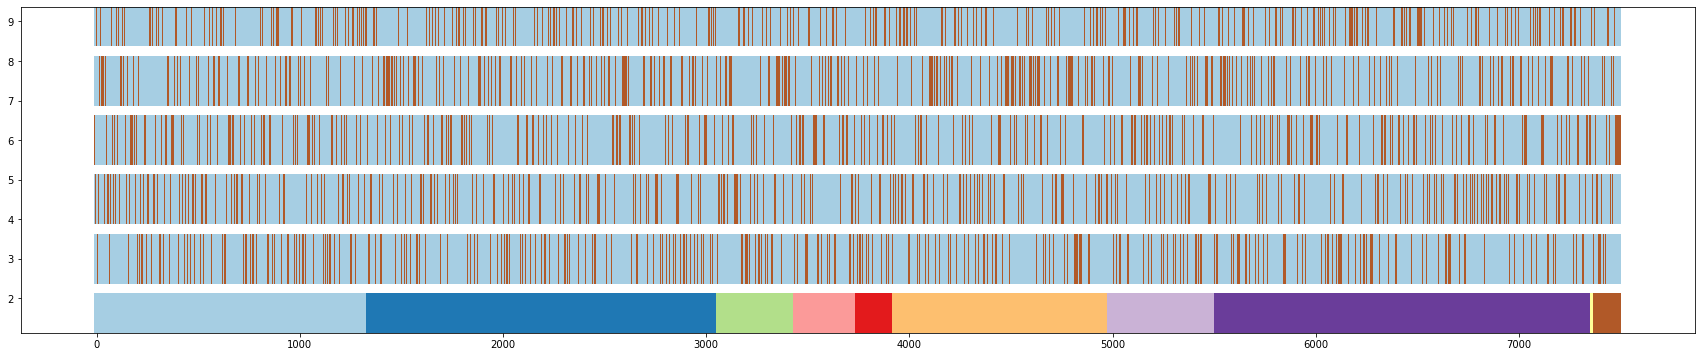

In [80]:
# category = []
# # 전체를 구한다. 
# for index in range(len(train_dataset)):
#     images, masks, image_infos =train_dataset[index]
#     categorys = np.unique(masks)
#     for cat in categorys:
#         if cat == 0: 
#             continue
#         # category, id
#         category.append([cat, index])
fig, ax = plt.subplots(figsize = (30, 6))

stratifiedkfold = StratifiedKFold(n_splits=5,random_state=2109,shuffle=True)
for i, idx in enumerate(stratifiedkfold.split(train_dataset, js_classes)):
    train_index, validate_index = idx
    # print(train_index, validate_index)
    #     kfod.sort(key= lambda x: (x[0], x[1]))
    scater_kfod = []
    for cat, _id in category:
        # if cat in [10]:
        if _id in validate_index:
            scater_kfod.append(1)
        else:
            scater_kfod.append(0)
    ax.scatter(range(len(scater_kfod)),  [(i+2) * 1.5 ]* len(scater_kfod), c=scater_kfod, marker='_',
                lw=50, cmap=cmap_data)
 

ax.scatter(range(len(scater_all)),  [1.5] * len(scater_all), c=scater_all, marker='_',
            lw=50, cmap=cmap_data)


In [53]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit, RepeatedMultilabelStratifiedKFold
msss = MultilabelStratifiedKFold(n_splits=5,  shuffle=True, random_state=2019)
# msss = MultilabelStratifiedShuffleSplit(n_splits=3, random_state=2019)

In [ ]:
import copy

In [44]:
from copy import deepcopy
Y = []
temp = [0 for _ in range(10)]
# 전체를 구한다. 
for index in range(len(train_dataset)):
    images, masks, image_infos =train_dataset[index]
    categorys = np.unique(masks)
    temp_2 = deepcopy(temp)
    for cat in categorys:
        if cat == 0: 
            continue
        temp_2[cat-1] = 1 
    Y.append(temp_2)
#         category.append([cat, index])

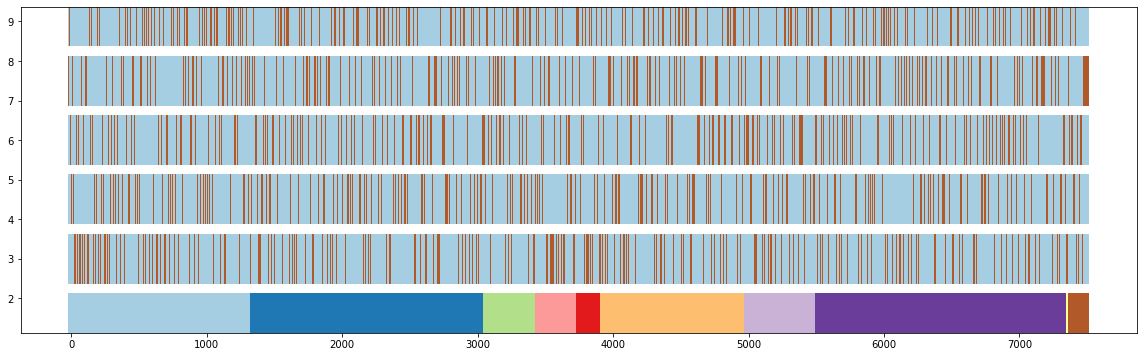

In [79]:
fig, ax = plt.subplots(figsize = (20, 6))
for i, (train_index, validate_index) in enumerate(msss.split(train_dataset, Y)):
    # print(f"train {train_index}, val {test_index}")
    scater_kfod = []
    temp = []   
    for cat, _id in category:
        # if cat in [10]:
        if _id in validate_index:
            scater_kfod.append(1)
        else:
            scater_kfod.append(0)
    ax.scatter(range(len(scater_kfod)),  [(i+2) * 1.5 ]* len(scater_kfod), c=scater_kfod, marker='_',
                lw=50, cmap=cmap_data)


ax.scatter(range(len(scater_all)),  [1.5] * len(scater_all), c=scater_all, marker='_',
        lw=50, cmap=cmap_data)


In [ ]:
# To better demonstrate the difference, we will assign samples to groups
# unevenly:
# print(X)
uneven_groups = np.sort(np.random.randint(0, 10, len(test)))

cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]


test

for cv in cvs:
    fig, ax = plt.subplots(figsize=(30, 3))
    plot_cv_indices(cv(n_splits), test, y, uneven_groups, ax, n_splits)
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)